In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from os.path import join as pjoin
import sys
import os
import pandas as pd
import numpy as np
import json
import lightgbm as lgb
from pathlib import Path
import plotly.express as px

add_path = pjoin(os.getcwd(), '..')
add_path = Path(add_path).resolve()
sys.path.insert(0, str(add_path))

from competition_scripts.competition_utils import (
    add_features_to_skeleton, calculate_scores, 
    join_datasets, perc_mae_lgb, percentage_mae
)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Load processed data

In [2]:
DATA_DIR_PROCESSED = pjoin('..', 'data', 'processed')
DATA_DIR_RAW = pjoin('..', 'data', 'raw')
df_train = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_train.parquet'))
df_test = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_test.parquet'))
df_sku = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_sku.parquet'))
df_geo = pd.read_parquet(pjoin(DATA_DIR_PROCESSED, 'df_geo.parquet'))

with open(pjoin(DATA_DIR_PROCESSED, 'col_mapping.json'), 'r') as f:
    colmapping_dict = json.load(f)
    
# important columns
group_cols = ('sku_id', 'geo_cluster_id')
date_col = 'date'
target_col = 'sales'

### Additional features

In [3]:
# https://pypi.org/project/holidays/
# !pip install holidays
import holidays

ua_holidays = holidays.UKR()
dates = sorted(set(
    df_train['date'].unique().tolist() + df_test['date'].unique().tolist()
))

holidays = []
for d in dates:
    holidays.append(int(d / 10**9) in ua_holidays)
    
is_holiday = dict(zip(dates, holidays))

df_train['is_holiday'] = df_train['date'].astype(np.int64).map(is_holiday)
df_test['is_holiday'] = df_test['date'].astype(np.int64).map(is_holiday)

In [4]:
# !pip install gensim
# nlp features
from gensim.models import Word2Vec

replace_regex = '[\s—,/]+'
sentences = (
    df_sku.title_en.str.lower().str.replace(replace_regex, ' ', regex=True)
    + ' '
    + df_sku.product_type_title_en.str.lower().str.replace(replace_regex, ' ', regex=True)
    + ' '
    + df_sku.commodity_group_title_en.str.lower().str.replace(replace_regex, ' ', regex=True)
    + ' '
    + df_sku.origin_country.str.lower().str.replace(replace_regex, ' ', regex=True)
)

sentences_series = sentences.str.replace('[0-9\.]+', '')
sentences_series = sentences_series[sentences_series.notnull()]

max_len = int(sentences_series.str.split('\s+').str.len().max())
print(max_len)
sentences = sentences_series.str.split('\s+').tolist()
sentences = [[w for w in s if len(w) > 1] for s in sentences]
sentences = [s for s in sentences if s]

w2v = Word2Vec(
    sentences=sentences,
    vector_size=8,
    window=max_len,
    min_count=1,
    batch_words=500,
    sg=0,
)

vocab = w2v.wv.key_to_index
print(f'words in vocab: {len(vocab)}')

print(w2v.wv.most_similar('banana', topn=7))

# build sku-level embeddings, simple averaging
sku_embs = {
    sku: np.zeros(w2v.vector_size)
    for sku in df_sku.index.tolist()
}
for i, s in sentences_series.items():
    tokens = s.split(' ')
    emb = np.zeros(w2v.vector_size)
    cnt = 0
    for t in tokens:
        if t in w2v.wv:
            emb += w2v.wv[t]
            cnt += 1
    if cnt != 0:
        emb /= cnt
    sku_embs[i] = emb
    
sku_embs = pd.DataFrame(sku_embs).T.astype(np.float32)
sku_embs.columns = [f'w2v_emb_{i+1}' for i in range(len(sku_embs.columns))]
sku_embs.index.name = 'sku_id'
sku_embs

16
words in vocab: 263
[('grapefruit', 0.9819385409355164), ('citrus', 0.981747567653656), ('como', 0.9787964820861816), ('pineapple', 0.9725760817527771), ('ring', 0.9706151485443115), ('confectionary', 0.97004634141922), ('alma', 0.9647417664527893)]


,w2v_emb_1,w2v_emb_2,w2v_emb_3,w2v_emb_4,w2v_emb_5,w2v_emb_6,w2v_emb_7,w2v_emb_8
sku_id,,,,,,,,
17,-0.716872,0.321292,-0.707063,-0.022085,1.764545,-0.008653,0.924416,-0.275503
18,-0.669873,0.327840,-0.673208,-0.067980,1.842483,-0.046386,0.816585,-0.097409
24,-0.707227,0.371000,-0.671079,-0.009214,1.770148,-0.035240,0.908821,-0.254924
25,-0.668448,0.260834,-0.716212,0.020404,1.630246,-0.108702,0.931127,-0.176972
208,0.715199,0.724162,0.014048,-1.339891,2.036143,-0.596404,0.392709,-1.506272
...,...,...,...,...,...,...,...,...
873803,-0.367455,0.587683,0.264018,-0.267745,1.139159,-0.149957,0.570977,-0.335485
873804,-0.306572,0.609754,0.414314,-0.058312,1.275297,-0.209827,0.665180,-0.143905
873805,-0.306572,0.609754,0.414314,-0.058312,1.275297,-0.209827,0.665180,-0.143905


In [5]:
# merge embeddings with dfs
df_train = df_train.merge(
    sku_embs.reset_index(),
    how='left',
    on='sku_id',
)

df_test = df_test.merge(
    sku_embs.reset_index(),
    how='left',
    on='sku_id',
)

### Train/val/test splits

In [88]:
val_period_pub_length = 7
val_period_pr_length = 7

train_period = [
    df_train[date_col].min(),
    df_train[date_col].max() - pd.Timedelta(
        days=val_period_pr_length + val_period_pub_length)
]
val_period_public = [
    df_train[date_col].max() - pd.Timedelta(
        days=val_period_pr_length + val_period_pub_length - 1),
    df_train[date_col].max() - pd.Timedelta(days=val_period_pr_length)
]
val_period_private = [
    df_train[date_col].max() - pd.Timedelta(days=val_period_pr_length - 1),
    df_train[date_col].max()
]

idx_train = (
    (df_train[date_col] >= train_period[0]) 
    & (df_train[date_col] <= train_period[1])
)

idx_train_last_month = (
    (df_train[date_col] >= train_period[1] - pd.Timedelta(days=28)) 
    & (df_train[date_col] <= train_period[1])
)

idx_train_last_month_for_correction = (
    (df_train[date_col] >= val_period_private[1] - pd.Timedelta(days=30)) 
    & (df_train[date_col] <= val_period_private[1])
)

idx_val = (
    (df_train[date_col] >= val_period_public[0]) 
    & (df_train[date_col] <= val_period_public[1])
)
idx_test = (
    (df_train[date_col] >= val_period_private[0]) 
    & (df_train[date_col] <= val_period_private[1])
)

assert (idx_test | idx_train | idx_val).mean() == 1.

In [7]:
# check baseline
grouping = ['sku_id', 'geo_cluster_id']
baseline_dict = df_train[idx_train_last_month].groupby(grouping)[target_col].median()

pred_baseline_val = \
df_train[idx_val].set_index(grouping).index.map(baseline_dict).fillna(0).values
pred_baseline_test = \
df_train[idx_test].set_index(grouping).index.map(baseline_dict).fillna(0).values

In [8]:
print('median baseline')
baseline_score_pub, baseline_score_pr = calculate_scores(
    df=df_train,
    idx_val=idx_val,
    idx_test=idx_test,
    pred_val=pred_baseline_val,
    pred_test=pred_baseline_test,
    grouping_col=date_col,
    target_col=target_col
)

median baseline
public : 0.93600
private: 0.93877



In [ ]:
df

### LGB datasets

In [24]:
categorical_feature = [
    'geo_cluster_id',
#     'sku_id',
    'city_id',
    'category_id', 
    'product_type_id', 
    'brand_id', 
    'trademark_id',
    'origin_country_id', 
    'commodity_group_id', 
#     'weekday', 
#     'week_no',
    'month',
]

cols_to_drop = [
    date_col,
#     'price_change_perc', # leak, assumption, when diff is null, target == 0
#     'price_change_logdiff', # leak, assumption, when diff is null, target == 0
    target_col
]

In [25]:
features = df_train[idx_train].drop(columns=[target_col] + cols_to_drop).columns.tolist()
assert set(categorical_feature).issubset(set(features))

# new_idx_train = idx_train.copy()
new_idx_train = (idx_train & df_train[target_col] > 0).copy()

ds_tr = lgb.Dataset(
    data=df_train.loc[
        idx_train,
#         new_idx_train,  # check metric change
        features
    ],
    label=df_train.loc[
        idx_train, 
#         new_idx_train,
        target_col
    ],
#     weight=np.log1p(df_train.loc[idx_train, target_col]),
    categorical_feature=categorical_feature,
    free_raw_data=False,
)

ds_val = lgb.Dataset(
    data=df_train.loc[idx_val, features],
    label=df_train.loc[idx_val, target_col],
#     weight=np.log1p(df_train.loc[idx_val, target_col]),
    categorical_feature=categorical_feature,
    reference=ds_tr,
    free_raw_data=False,
)

ds_tr.grouping_ = df_train.loc[idx_train, date_col].copy()
ds_val.grouping_ = df_train.loc[idx_val, date_col].copy()

In [26]:
lgb_params = {
    'early_stopping_round': 25,
    'num_iterations': 100,
#     'objective': 'tweedie', # ?
    'objective': 'mae',
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 127,
    'seed': 42,
    'deterministic': True,
    'max_depth': 10,
    'min_data_in_leaf': 50,
    'feature_fraction': 1.,
    'max_cat_to_onehot': 10,
    'cat_l2': 2.,
    'cat_smooth': 1.,
    'verbosity': 1,
}

In [27]:
model = lgb.train(
    params=lgb_params,
    train_set=ds_tr,
    feval=perc_mae_lgb(),
    valid_sets=[
#         ds_tr, 
        ds_val
    ],
    valid_names=[
#         'train_all', 
        'val_public'
    ],
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.415335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3784
[LightGBM] [Info] Number of data points in the train set: 26356037, number of used features: 24
[1]	val_public's l1: 0.185017	val_public's perc_mae: 0.992558
Training until validation scores don't improve for 25 rounds
[2]	val_public's l1: 0.183792	val_public's perc_mae: 0.986036
[3]	val_public's l1: 0.182598	val_public's perc_mae: 0.979678
[4]	val_public's l1: 0.181326	val_public's perc_mae: 0.972898
[5]	val_public's l1: 0.180038	val_public's perc_mae: 0.966035
[6]	val_public's l1: 0.178753	val_public's perc_mae: 0.959192
[7]	val_public's l1: 0.177507	val_public's perc_mae: 0.952562
[8]	val_public's l1: 0.176414	val_public's perc_mae: 0.946735
[9]	val_public's l1: 0.175407	val_public's perc_mae: 0.941362
[10]	val_public's l1: 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

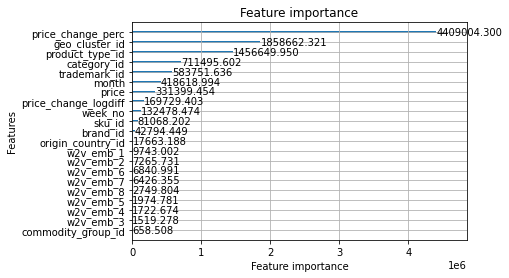

In [63]:
# check learned importances
lgb.plot_importance(model, importance_type='gain')

In [30]:
ml_pred_test = model.predict(
    data=df_train.loc[idx_test, features]
)

ml_pred_val = model.predict(
    data=df_train.loc[idx_val, features]
)

print('ML baseline')
ml_score_pub, ml_score_pr = calculate_scores(
    df=df_train,
    idx_val=idx_val,
    idx_test=idx_test,
    pred_val=ml_pred_val,
    pred_test=ml_pred_test,
    grouping_col=date_col,
    target_col=target_col
)

ML baseline
public : 0.89267
private: 0.89909



### Make submission

In [31]:
ml_pred_sub = model.predict(
    data=df_test.loc[:, features]
)

In [35]:
ml_pred_sub = np.clip(ml_pred_sub, 0, np.inf)
ml_pred_sub.min()

0.0

In [40]:
# load sample submission
SUBMISSION_DIR = pjoin('..', 'submissions')

subm = pd.read_csv(pjoin(DATA_DIR_RAW, 'sample_final.csv'))
subm['sales'] = ml_pred_sub
subm['sales'] = subm['sales'].fillna(0.)

score_pub = str(round(ml_score_pub, 5)).replace('.', '_')
score_pr = str(round(ml_score_pr, 5)).replace('.', '_')
subm_name = f'baseline_lgb_with_price_leak_pub={score_pub}_pr={score_pr}.csv'
subm.to_csv(
    pjoin(SUBMISSION_DIR, subm_name),
    index=False
)

print(subm_name)

baseline_lgb_with_price_leak_pub=0_89267_pr=0_89909.csv
